In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import hddm
import arviz as az
import seaborn as sns
import numpy as np
import warnings
import sys 
import os  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
version=1 # 两种模型
id=2 #实验编号
#### don't modify
prefix='/home/jovyan'
user=f'weight/v{version}'
sample_num=20
burn_num=2
chains_num=2


## exp

### data

##### load

In [3]:
data = hddm.load_csv(f'{prefix}/data/exp{id}.csv')
data = hddm.utils.flip_errors(data)
data

,subj_idx,response,rt,dif,Info,Third
0,1,1,0.95122,1.84,MV,high
1,1,1,0.80034,2.02,MV,mid
2,1,1,0.61676,1.78,MV,low
3,1,1,0.98371,2.10,MV,high
4,1,1,0.55052,2.10,MV,high
...,...,...,...,...,...,...
12926,109,1,1.11700,1.85,MV,high
12927,109,1,1.93390,1.95,MV,high
12928,109,1,0.65037,1.93,MV,mid
12929,109,1,0.86726,1.90,MV,mid


##### analysis

In [4]:
data.describe()

,subj_idx,response,rt,dif
count,12931.000000,12931.000000,12931.000000,12931.000000
mean,63.434846,0.697394,0.415898,1.601150
std,31.856780,0.459404,1.164922,0.550679
min,1.000000,0.000000,-4.183900,0.010000
25%,37.000000,0.000000,-0.717245,1.150000
50%,73.000000,1.000000,0.800630,1.870000
75%,90.000000,1.000000,1.150400,1.970000
max,109.000000,1.000000,4.233900,3.220000


<AxesSubplot: xlabel='dif', ylabel='Density'>

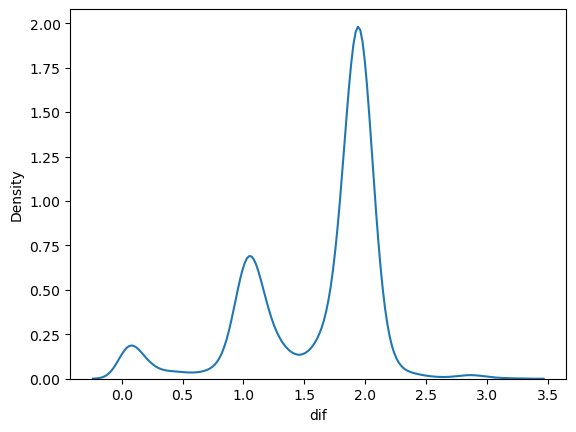

In [5]:
sns.kdeplot(data['dif'])

In [6]:
data[data['Info']=='EV'].groupby('Third')[['rt','response','dif']].mean()

,rt,response,dif
Third,,,
high,0.490056,0.746753,1.554174
low,0.293493,0.630415,1.472493
mid,0.428338,0.709840,1.777057


In [7]:
data[data['Info']=='MV'].groupby('Third')[['rt','response','dif']].mean()

,rt,response,dif
Third,,,
high,0.499628,0.740896,1.558992
low,0.359947,0.660122,1.459738
mid,0.424727,0.696587,1.782959


### load

In [8]:
rc=az.from_netcdf(f'{prefix}/{user}/exp_{id}_v{version}.nc')
pwd=os.getcwd()
os.chdir(f'{prefix}/{user}/')
model=hddm.load(f'{prefix}/{user}/exp_{id}_v{version}')
os.chdir(pwd)

### train

In [9]:
# if version==1:
#     v_func=["v~dif+C( Third,Treatment('mid'))*C(Info, Treatment('MV'))","a~C(Third, Treatment('mid'))*C(Info, Treatment('MV'))"]
# elif version==2:
#     v_func=["v~dif*C(Third, Treatment('mid'))*C(Info, Treatment('MV'))","a~C(Third, Treatment('mid'))*C(Info, Treatment('MV'))"]
# else:
#     raise NotImplementedError
# model = hddm.HDDMRegressor(data, ["v~dif*C(Third, Treatment('mid'))*C(Info, Treatment('MV'))","a~C(Third, Treatment('mid'))*C(Info, Treatment('MV'))"],
#                          p_outlier=0.05,
#                          group_only_regressors = False,
#                          include = ('v','a','t'))
# rc = model.sample(sample_num,chains=chains_num, burn=burn_num,dbname=f'{prefix}/work/exp_{id}_v{version}.db',db='pickle',return_infdata=True, sample_prior=True, loglike=True, ppc=True)
# model.save(f'{prefix}/{user}/exp_{id}_v{version}')
# az.to_netcdf(rc, f'{prefix}/{user}/exp_{id}_v{version}.nc')

### model evaluate

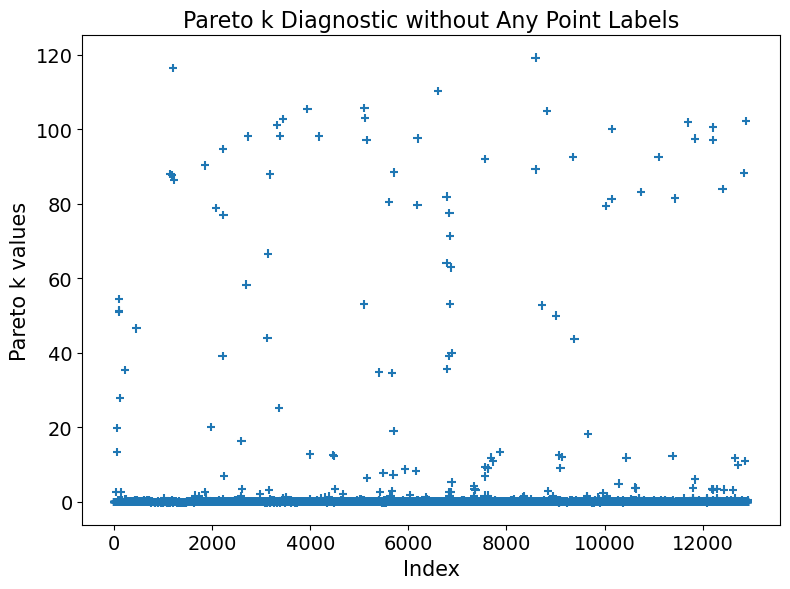

In [10]:
# khats = az.loo(rc,pointwise=True)
# az.plot_khat(khats, xlabels=True, threshold=0.8)
# khats

khats = az.loo(rc, pointwise=True)

fig, ax = plt.subplots(figsize=(8, 6))
az.plot_khat(khats, xlabels=False, threshold=0.8, ax=ax, show=False)

# 去除线条标签
for line in ax.get_lines():
    line.set_label("")

# 清除所有的文本标签（包括索引）
for text in ax.texts:
    text.set_visible(False)

ax.set_title("Pareto k Diagnostic without Any Point Labels", fontsize=16)
ax.set_xlabel("Index")
ax.set_ylabel("Pareto k values")
plt.tight_layout()
plt.show()


<AxesSubplot: xlabel='rt / rt\n18'>

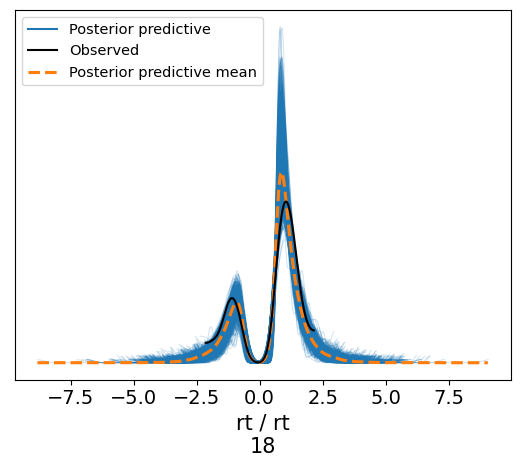

In [11]:
rc_ = rc.assign_coords(
  obs_id=rc.observed_data.coords['subj_idx'].values, 
  groups="observed_vars")

az.plot_ppc(rc_, var_names= 'rt', coords={'obs_id': [18]}, flatten=[])

In [12]:
f'dic:{model.dic:.4f}'

'dic:24845.6336'

In [13]:
summary_tmp = az.summary(rc, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"v_C(Third, Treatment('mid'))[T.high]:C(Info, Treatment('MV'))[T.EV]",0.0447,0.0328,7.9791,21.3684,1.1937
"v_C(Third, Treatment('mid'))[T.high]",0.0486,0.0352,12.8657,38.6426,1.1581
"v_dif:C(Third, Treatment('mid'))[T.high]:C(Info, Treatment('MV'))[T.EV]",0.0251,0.0183,10.0992,20.3976,1.1558
"v_dif:C(Third, Treatment('mid'))[T.high]",0.0280,0.0203,12.9694,44.1379,1.1517
"v_C(Third, Treatment('mid'))[T.low]",0.0463,0.0334,12.9167,68.8393,1.1428
v_Intercept,0.0336,0.0242,15.0069,49.0051,1.1412
"v_dif:C(Third, Treatment('mid'))[T.low]",0.0267,0.0193,13.6608,83.8904,1.1328
v_dif,0.0171,0.0124,18.5210,51.0264,1.1251
"v_dif:C(Info, Treatment('MV'))[T.EV]",0.0088,0.0063,18.7888,133.5934,1.1040
"v_C(Third, Treatment('mid'))[T.high]:C(Info, Treatment('MV'))[T.EV]_subj.92",0.0440,0.0316,16.2749,36.0649,1.1034


In [14]:
rc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> prior
	> observed_data

### $P_{post}$

In [15]:
params=model.get_traces()
p_post=(params["v_dif:C(Third, Treatment('mid'))[T.high]"]>0).mean()
p_post

0.9343

### merge

##### two functions for different model

In [16]:
def get_param1(dif,prefix=''): #_subj.3
    params=model.get_traces()
    Third=['low','mid','high']
    Info=['EV','MV']
    params_list=[]
    for third in Third:
        for info in Info:
            v=params[f'v_dif{prefix}']*dif+params[f'a_Intercept{prefix}']
            a=params[f'a_Intercept{prefix}']
            if third!='mid':
                v+=params[f"v_C(Third, Treatment('mid'))[T.{third}]{prefix}"]
                a+=params[f"a_C(Third, Treatment('mid'))[T.{third}]{prefix}"]
            if info!='MV':
                v+=params[f"v_C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                a+=params[f"a_C(Info, Treatment('MV'))[T.{info}]{prefix}"]
            if third!='mid' and info!='MV':
                v+=params[f"v_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                a+=params[f"a_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
            params_list.append(pd.DataFrame({"Third":third,"Info":info,"v":v,"a":a}))
    dmm_param=pd.concat(params_list,axis=0, ignore_index=True)
    return dmm_param


In [17]:
def get_param2(dif,prefix=''):
    params_list=[]
    params=model.get_traces()
    Third=['low','mid','high']
    Info=['EV','MV']
    for third in Third:
        for info in Info:
            v=params[f'a_Intercept{prefix}']
            beta=params[f'v_dif{prefix}']
            a=params[f'a_Intercept{prefix}']
            if third!='mid':
                v+=params[f"v_C(Third, Treatment('mid'))[T.{third}]{prefix}"]
                beta+=params[f"v_dif:C(Third, Treatment('mid'))[T.{third}]{prefix}"]
                a+=params[f"a_C(Third, Treatment('mid'))[T.{third}]{prefix}"]
            if info!='MV':
                v+=params[f"v_C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                beta+=params[f"v_dif:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                a+=params[f"a_C(Info, Treatment('MV'))[T.{info}]{prefix}"]
            if third!='mid' and info!='MV':
                v+=params[f"v_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                beta+=params[f"v_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                a+=params[f"a_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
            V=v+beta*dif
            params_list.append(pd.DataFrame({"Third":third,"Info":info,"v":V,"a":a}))
    dmm_param=pd.concat(params_list,axis=0, ignore_index=True)
    return dmm_param

##### exec

In [18]:
# 提取 posterior predictive 检查数据
ppc_data = rc.posterior_predictive # 提取预测数据
observed_data = rc.observed_data   # 提取真实数据

# 转换为 DataFrame 格式，方便分组与可视化
ppc_df = ppc_data.to_dataframe()       # 模型预测数据
obs_df = observed_data.to_dataframe()  # 真实观测数据
aligned_df = pd.merge(obs_df, ppc_df, on='obs_id', suffixes=('_obs', '_pred'))
# 重构数据用于小提琴图
obs_values = pd.DataFrame({
    'Third': aligned_df['Third'],
    'Info':aligned_df['Info'],
    'rt': aligned_df['rt_obs'],
    'abs_rt':aligned_df['rt_pred'].abs(),
    'response':aligned_df['response_obs'],
    'Type': 'Observed'  # 真实值标签
})

pred_values = pd.DataFrame({
    'Third': aligned_df['Third'],
    'Info':aligned_df['Info'],
    'rt': aligned_df['rt_pred'],
    'abs_rt':aligned_df['rt_pred'].abs(),
    'response':aligned_df['response_pred'],
    'Type': 'Predicted'  # 预测值标签
})

# 合并数据
final_df = pd.concat([obs_values, pred_values])
final_df_cue=final_df[final_df['Info']=='EV']
final_df_no=final_df[final_df['Info']=='MV']
final_df

,Third,Info,rt,abs_rt,response,Type
obs_id,,,,,,
0,high,MV,0.951220,0.863611,1,Observed
0,high,MV,0.951220,0.859262,1,Observed
0,high,MV,0.951220,0.871503,1,Observed
0,high,MV,0.951220,0.873966,1,Observed
0,high,MV,0.951220,0.875981,1,Observed
...,...,...,...,...,...,...
12930,mid,MV,-3.894318,3.894318,0,Predicted
12930,mid,MV,0.995139,0.995139,1,Predicted
12930,mid,MV,-1.601375,1.601375,0,Predicted


In [19]:
v_dif=data['dif'].mean()
dmm_param=eval(f"get_param{version}(v_dif)")
dmm_param

,Third,Info,v,a
0,low,EV,2.141432,1.680746
1,low,EV,2.013526,1.628166
2,low,EV,2.097529,1.718461
3,low,EV,1.919838,1.577662
4,low,EV,2.070305,1.696611
...,...,...,...,...
59995,high,MV,2.209881,1.470617
59996,high,MV,2.279336,1.455485
59997,high,MV,2.322389,1.516407
59998,high,MV,2.128606,1.433772


### visualize

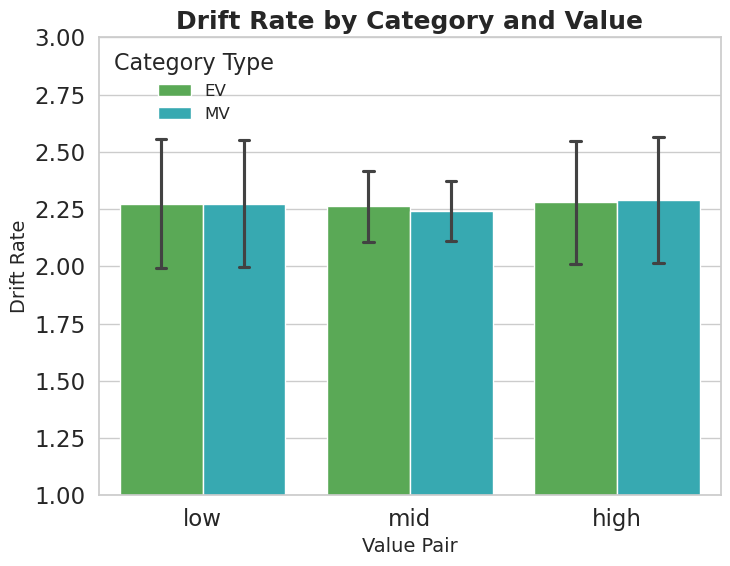

In [33]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
plt.figure(figsize=(7.5, 6))
sns.barplot(
    x='Third',
    y='v',
    hue='Info',
    data=dmm_param,
    palette={'EV': '#4DB748', 'MV': '#23BAC5'},
    ci="sd",  # 置信区间，使用标准差表示
    capsize=0.1  # 添加误差线的小帽
)
plt.title("Drift Rate by Category and Value", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("Drift Rate", fontsize=14)
plt.legend(title="Category Type", title_fontsize=16, loc="upper left", fontsize=12, frameon=False)
plt.tight_layout()
plt.ylim(1, 3)  # 设置 y 轴范围
plt.show()


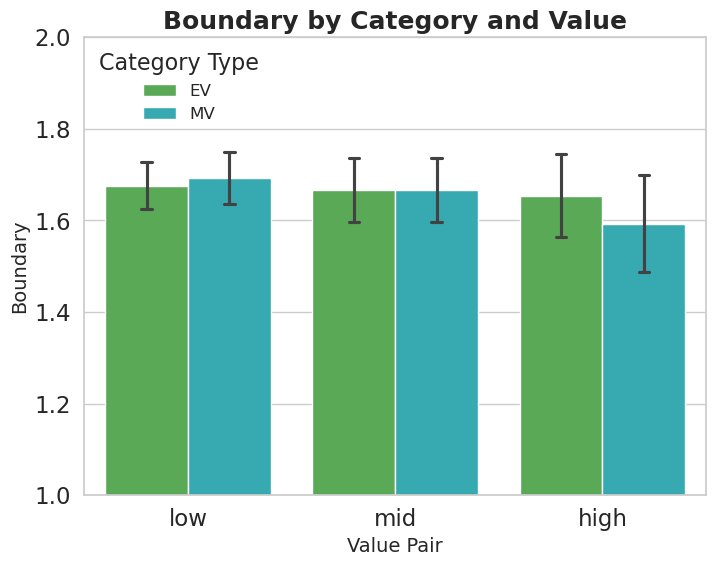

In [34]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
plt.figure(figsize=(7.5, 6)) 
sns.barplot(
    x='Third',
    y='a',
    hue='Info',
    data=dmm_param,
    palette={'EV': '#4DB748', 'MV': '#23BAC5'},
    ci="sd",  # 显示标准差
    capsize=0.1
)
plt.title("Boundary by Category and Value", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("Boundary", fontsize=14)
plt.legend(title="Category Type", title_fontsize=16, loc="upper left", fontsize=12, frameon=False)
plt.ylim(1, 2)  # 设置 y 轴范围
plt.tight_layout()
plt.show()


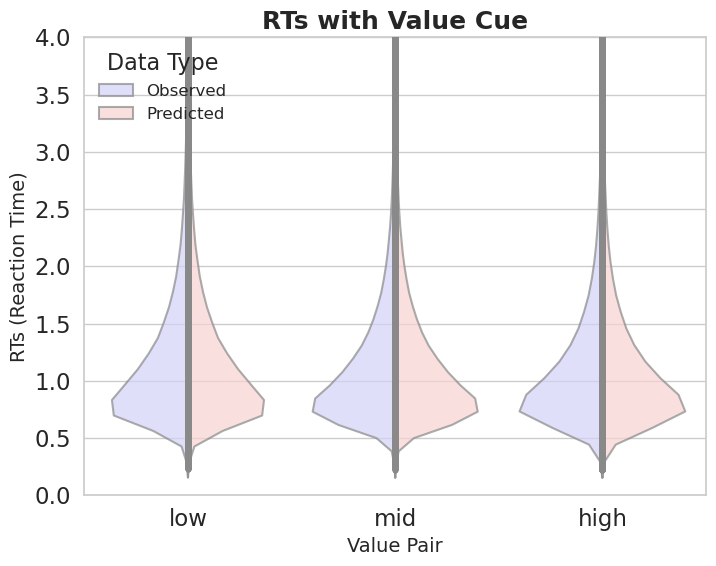

In [22]:
# 设置 Seaborn 风格
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
order = ['low', 'mid', 'high']  # 按照期望顺序排列

# 绘制真实值与预测值的小提琴图
plt.figure(figsize=(7.5, 6))  # 增加图像尺寸
ax = sns.violinplot(
    x='Third',
    y='abs_rt',
    hue='Type',
    data=final_df_cue,
    palette={'Observed': '#ccccfe', 'Predicted': '#ffcccc'},  # 使用更具对比的颜色
    split=True,  # 在同一位置展示两类分布
    inner="point",  # 使用点显示内部分布，去掉四分位线
    order=order,
    linewidth=1.5,  # 设置线条宽度
    scale='area',  # 让小提琴图的面积均匀
    alpha=0.7  # 设置透明度
)

# 添加标题与标签
plt.title("RTs with Value Cue(exp2)", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("RTs (Reaction Time)", fontsize=14)
plt.ylim(0, 4)  # 设置 y 轴范围

# 调整图例位置和样式
plt.legend(title="Data Type", title_fontsize=16, loc="upper left", fontsize=12, frameon=False)

# 改善布局
plt.tight_layout()

# 显示图像
plt.show()


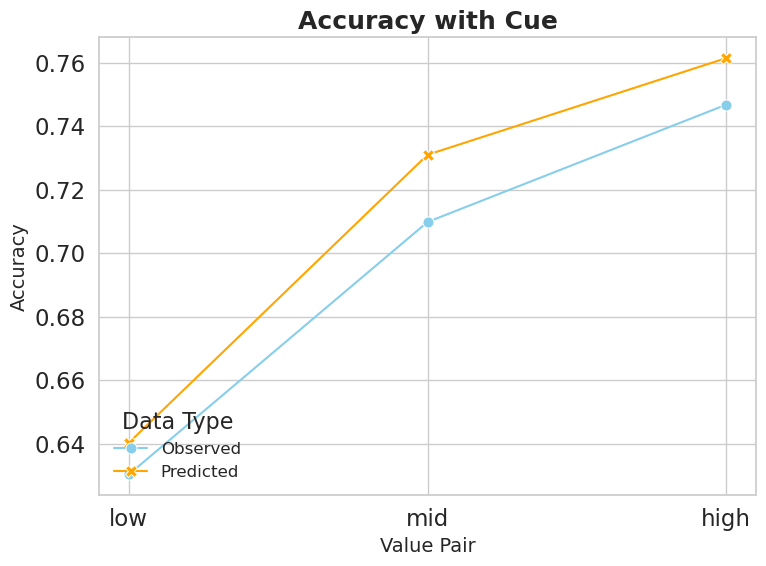

In [23]:
# 设置 Seaborn 风格
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
final_df_cue['Third'] = pd.Categorical(final_df_cue['Third'], categories=['low', 'mid', 'high'], ordered=True)
order = ['low', 'mid', 'high']  # 按照期望顺序排列

# 绘制折线图
plt.figure(figsize=(8, 6))  # 增加图像尺寸
ax = sns.lineplot(
    x='Third',  # x 轴为组别
    y='response',  # y 轴为响应值
    hue='Type',  # 根据 'Type' 分别画出不同颜色的线
    data=final_df_cue,
    style='Type',  # 使 'Type' 用不同的线型区分
    markers=True,  # 显示每个点的标记
    dashes=False,  # 不使用虚线
    palette={'Observed': 'skyblue', 'Predicted': 'orange'},  # 使用对比强烈的颜色
    markersize=8,  # 标记点的大小
    ci=None  # 不显示置信区间
)

# 添加标题与标签
plt.title("Accuracy with Cue", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# 调整图例位置和样式
plt.legend(title="Data Type", title_fontsize=16, loc="lower left", fontsize=12, frameon=False)

# 改善布局
plt.tight_layout()

# 显示图像
plt.show()


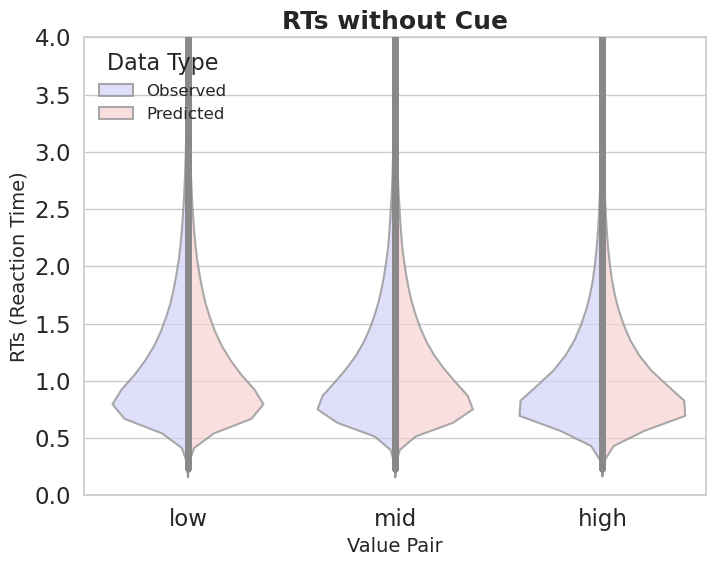

In [24]:
# 设置 Seaborn 风格
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
order = ['low', 'mid', 'high']  # 按照期望顺序排列

# 绘制真实值与预测值的小提琴图
plt.figure(figsize=(7.5, 6))  # 增加图像尺寸
ax = sns.violinplot(
    x='Third',
    y='abs_rt',
    hue='Type',
    data=final_df_no,
    palette={'Observed': '#ccccfe', 'Predicted': '#ffcccc'},  # 使用更具对比的颜色
    split=True,  # 在同一位置展示两类分布
    inner="point",  # 使用点显示内部分布，去掉四分位线
    linewidth=1.5,  # 设置线条宽度
    order=order,
    scale='area',  # 让小提琴图的面积均匀
    alpha=0.7  # 设置透明度
)

# 添加标题与标签
plt.title("RTs without Cue", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("RTs (Reaction Time)", fontsize=14)
plt.ylim(0, 4)  # 设置 y 轴范围为 0 到 5

# 调整图例位置和样式
plt.legend(title="Data Type", title_fontsize=16, loc="upper left", fontsize=12, frameon=False)

# 改善布局
plt.tight_layout()

# 显示图像
plt.show()


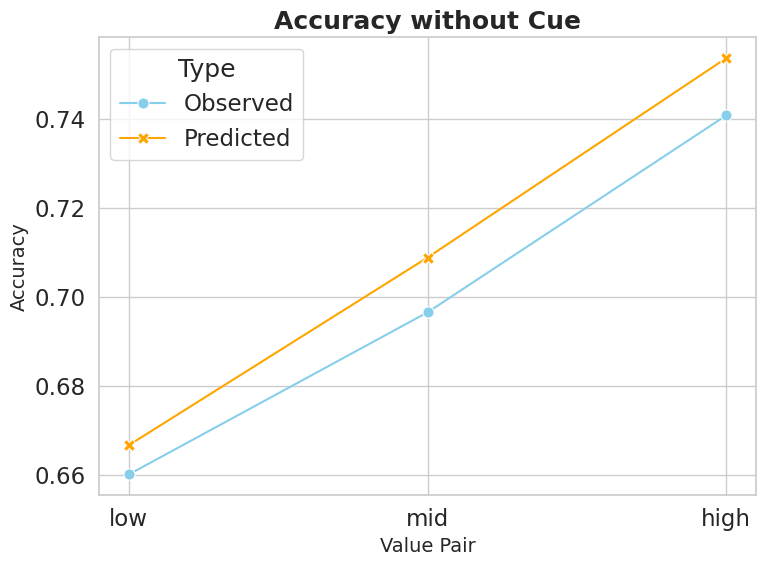

In [25]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
final_df_no['Third'] = pd.Categorical(final_df_no['Third'], categories=['low', 'mid', 'high'], ordered=True)
plt.figure(figsize=(8, 6))  # 增加图像尺寸
ax = sns.lineplot(
    x='Third',  # x 轴为组别
    y='response',  # y 轴为响应值
    hue='Type',  # 根据 'Type' 分别画出不同颜色的线
    data=final_df_no,
    style='Type',  # 使 'Type' 用不同的线型区分
    markers=True,  # 显示每个点的标记
    dashes=False,  # 不使用虚线
    palette={'Observed': 'skyblue', 'Predicted': 'orange'},  # 使用对比强烈的颜色
    markersize=8,  # 标记点的大小
    ci=None  # 不显示置信区间
)
plt.title("Accuracy without Cue", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.tight_layout()
plt.show()